In [1]:
%load_ext autoreload
%autoreload 1
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [14, 10]

import torch
from torch.utils.data import Dataset
from retinanet.encoder import DataEncoder
import imgaug as ia
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
from retinanet.retinanet import RetinaNet
from retinanet.loss import FocalLoss
from pikachu_dataset import load_data_pikachu

In [2]:
class PikachuDataset(Dataset):
    def __init__(self, anchor_areas=None):
        
        self.anchor_areas = anchor_areas
        self.train, self.val = load_data_pikachu(1)
    
        encoder = DataEncoder()
        if self.anchor_areas is not None:
            encoder.anchor_areas = self.anchor_areas  # p3 -> p7
            
        self.encoder = encoder 
        
    def __len__(self):
        return 900 #magic number thats how many images are in the pikachu dataset
        
    def __getitem__(self, i):
        try:
            b = self.train.next()
        except StopIteration:
            self.train.reset()
            b = self.train.next()
            
        image = b.data[0].asnumpy()
        bbox = b.label[0].asnumpy()[:, 0, 1:] * 256
        label = b.label[0].asnumpy()[:, 0, 0]
    
        return torch.from_numpy(image), torch.from_numpy(bbox), torch.from_numpy(label)    
    
    def collate_func(self, batch):

        images = [b[0][0] for b in batch]
        bbox = [b[1] for b in batch]
        labels = [b[2] for b in batch]
        
        encoded = [self.encoder.encode(bb, l, torch.Tensor([256, 256])) for bb, l in zip(bbox, labels)]
        loc_target = [l[0] for l in encoded]
        cls_target = [l[1] for l in encoded]

        return torch.stack(images) / 255, torch.stack(loc_target), torch.stack(cls_target)
        
def init_weights_retina(module, pi=0.02):
    if hasattr(module, 'name'):
        b = -log((1 - pi) / pi)
        if module.name == 'final_layer':
            module.bias.data.fill_(b)
        elif module.name == 'head_layer':
            module.weight.data.normal_(0, pi)
            module.bias.data.fill_(0)           

In [3]:
pikachu_ds =PikachuDataset()
pikachu_dl = DataLoader(pikachu_ds, batch_size=8, collate_fn=pikachu_ds.collate_func)

In [5]:
device  = 'cuda' if torch.cuda.is_available() else 'cpu'

model = RetinaNet(1)
model = model.to(device)

model.freeze_bn()
for param in model.fpn.parameters():
    param.requires_grad = False

model.apply(init_weights_retina)

RetinaNet(
  (fpn): FPN(
    (encoder): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
          

In [6]:
criterion = FocalLoss(1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00004)

collect = []
for epoch in range(5):
    for b in pikachu_dl:
        optimizer.zero_grad()
        image, bounding_boxes, labels = b
        image = image.to(device)
        bounding_boxes = bounding_boxes.to(device)
        labels = labels.to(device)
        loc_pred, cls_pred = model(image)
        total_loss = criterion(loc_pred, bounding_boxes, cls_pred, labels)
        total_loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 1)
        optimizer.step()
        collect.append([total_loss])
        print("total loss {}".format(total_loss))
        

/opt/conda/envs/dsr/lib/python3.6/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/opt/conda/envs/dsr/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/conda/envs/dsr/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/opt/conda/envs/dsr/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.uti

total loss 12704.8134765625
total loss 12609.9990234375
total loss 12494.3037109375
total loss 12390.0185546875
total loss 12263.982421875
total loss 12112.626953125
total loss 11960.2626953125
total loss 11689.1064453125
total loss 11339.716796875
total loss 10983.8896484375
total loss 10563.5009765625
total loss 10012.7978515625
total loss 9619.2236328125
total loss 8542.5830078125
total loss 8142.796875
total loss 7028.6708984375
total loss 5762.6357421875
total loss 5000.69384765625
total loss 4028.21484375
total loss 3599.958740234375
total loss 2806.39892578125
total loss 2639.0869140625
total loss 1967.360595703125
total loss 1795.0113525390625
total loss 1351.4278564453125
total loss 1148.665283203125
total loss 1106.9208984375
total loss 988.8101196289062
total loss 941.8988037109375
total loss 854.23974609375
total loss 873.0179443359375
total loss 823.482666015625
total loss 771.2008666992188
total loss 863.0413818359375
total loss 890.3700561523438
total loss 760.0498046875

total loss 119.23828125
total loss 92.68769836425781
total loss 85.76754760742188
total loss 87.42239379882812
total loss 69.81253051757812
total loss 71.19673156738281
total loss 79.00831604003906
total loss 88.6673812866211
total loss 68.25735473632812
total loss 75.55997467041016
total loss 87.33175659179688
total loss 99.70109558105469
total loss 77.14875793457031
total loss 83.18179321289062
total loss 73.9558334350586
total loss 91.34149169921875
total loss 73.54121398925781
total loss 60.80469512939453
total loss 80.24922943115234
total loss 69.48394775390625
total loss 76.81268310546875
total loss 66.9939956665039
total loss 98.47380065917969
total loss 77.3731689453125
total loss 67.76649475097656
total loss 77.37051391601562
total loss 69.95332336425781
total loss 72.88028717041016
total loss 70.09940338134766
total loss 76.60631561279297
total loss 89.0822982788086
total loss 118.1043472290039
total loss 78.14311218261719
total loss 85.08639526367188
total loss 85.5758361816

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe984049780>],
      dtype=object)

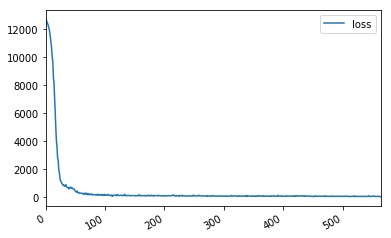

In [7]:
import pandas as pd
pd.DataFrame(collect, columns=['loss']).astype(float).plot(subplots=True)

# Visualizing Results

In [8]:
it = iter(pikachu_dl)

/opt/conda/envs/dsr/lib/python3.6/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/opt/conda/envs/dsr/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


failed in nnms


Text(0.5, 1.0, 'score 0.37523525953292847')

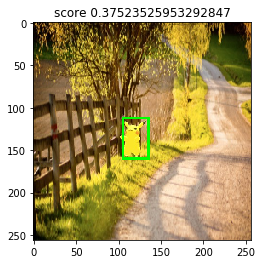

In [9]:
model.eval()
b = next(it)
i = 0
image, bounding_boxes, labels = b
loc_pred, cls_pred = model(image.cuda())

bbspred, labelpred, score  = pikachu_ds.encoder.decode(loc_pred[i].float().cpu(), 
                                                       cls_pred[i].float().cpu(), 
                                                       torch.Tensor([256, 256]).float().cpu()
                                                      )

image_to_show = np.moveaxis(image[i].detach().cpu().numpy(),0, 2)

matched_anchors_on_image = ia.BoundingBoxesOnImage(
    [ia.BoundingBox(*b) for b in bbspred.detach().cpu().numpy()], shape=(256, 256))

image_to_show = matched_anchors_on_image.draw_on_image(image_to_show, thickness=3)
plt.imshow(image_to_show)
plt.title('score ' + str(float(score)))

Original image size = (320, 213)
Resized image size = (385, 256)
Cropped image size = (256, 256)
Tensor size = torch.Size([1, 3, 256, 256])
failed in nnms


Text(0.5, 1.0, 'score tensor([0.9971])')

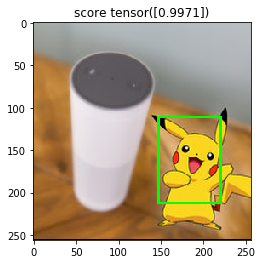

In [20]:
from PIL import Image
from random import randint
test_image = Image.open("pikachu3.jpg").convert("RGB")
print(f'Original image size = {test_image.size}')
if (np.array(test_image.size) < 256).any():
    resizing_factor = 256 / (test_image.size[np.argmin(np.array(test_image.size))])
    test_image = test_image.resize(
        (int(np.ceil(test_image.size[0] * resizing_factor)), int(np.ceil(test_image.size[1] * resizing_factor))), 
        Image.ANTIALIAS)
print(f'Resized image size = {test_image.size}')
top_crop    = randint(0, test_image.size[0] - 255)
left_crop   = randint(0, test_image.size[1] - 255)
bottom_crop = top_crop + 256
right_crop  = left_crop + 256
test_image = test_image.crop((top_crop, left_crop, bottom_crop, right_crop))
print(f'Cropped image size = {test_image.size}')
plt.imshow(test_image)
test_image = torch.Tensor(np.array(test_image) / 255)
test_image = test_image.permute(2,0,1).contiguous().unsqueeze(dim = 0).to(device)
print(f'Tensor size = {test_image.shape}')
loc_pred, cls_pred = model(test_image)

cls_pred = torch.Tensor(np.array(cls_pred.detach().cpu()) + 6)

bbspred, labelpred, score  = pikachu_ds.encoder.decode(
    loc_pred[i].float().cpu(), 
    cls_pred[i].float().cpu(), 
    torch.Tensor([256, 256]).float().cpu()
)

image_to_show = np.moveaxis(
    test_image.squeeze().detach().cpu().numpy(),0, 2)

matched_anchors_on_image = ia.BoundingBoxesOnImage(
    [ia.BoundingBox(*b) for b in bbspred.detach().cpu().numpy()], shape=(256, 256))

image_to_show = matched_anchors_on_image.draw_on_image(image_to_show, thickness=3)
plt.imshow(image_to_show)
plt.title('score ' + str(score))